# Testing code for cost function "elasticity" on the annulus

In [1]:
%pylab inline

import dionysus

Populating the interactive namespace from numpy and matplotlib


## Constructing the annulus and combuting the cocycle

(-2.1739925627919297,
 2.136918728167798,
 -2.188061289288732,
 2.1700139395749476)

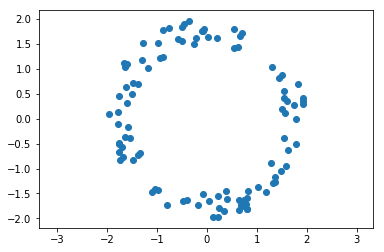

In [2]:
R = 1.5
d = .5
n = 100

# r in [0,1]
# th in [0,2pi)

from math import sin, cos, pi
from random import uniform
def rand_annulus_pt():
    r = uniform(0,1)
    th = uniform(0,2*pi)
    return (R+r*d) * cos(th), (R+r*d) * sin(th)
annulus = np.array([(rand_annulus_pt()) for x in range(100)])
plt.scatter(*annulus.T)
plt.axis('equal')

In [3]:
prime = 19
vr = dionysus.fill_rips(annulus, 2, 4.)
cp = dionysus.cohomology_persistence(vr, prime, True)
dgms = dionysus.init_diagrams(cp, vr)

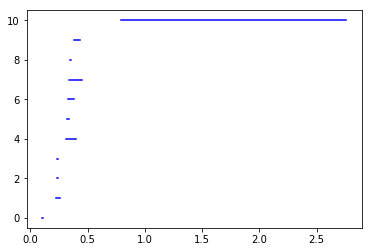

In [4]:
dionysus.plot.plot_bars(dgms[1], show=True)

In [5]:
bars = [bar for bar in dgms[1] if bar.death > 1.]
bars

[(0.790175,2.75954)]

In [6]:
cocycles = [cp.cocycle(bar.data) for bar in bars]
vr_8 = dionysus.Filtration([s for s in vr if s.data <= 1.0])
coords = [dionysus.smooth(vr_8, cocycle, prime) for cocycle in cocycles]

(-2.1739925627919297,
 2.136918728167798,
 -2.188061289288732,
 2.1700139395749476)

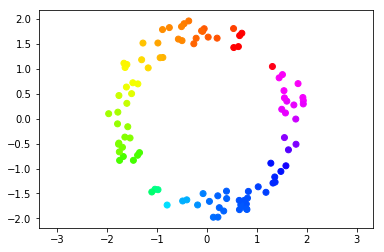

In [7]:
# subplot(121)#, projection="3d")
scatter(*annulus.T, c=coords[0], cmap="hsv")
plt.axis('equal')

# subplot(122)#, projection="3d")
# scatter(*annulus.T, c=coords[1], cmap="hsv")

## Running TensorFlow

In [8]:
import tensorflow as tf
# import coboundary_D2 as cbd

In [25]:
D = {}
data = {}
indexing = {}
ix = [0]*50
thr = 3
for s in vr:
    if s.dimension() == 0:
        continue
    elif s.data > thr:
        break
    D.setdefault(s.dimension(),[[],[]])
    data.setdefault(s.dimension(),[])
    indexing.setdefault(s.dimension(),{})
    indexing.setdefault(s.dimension()-1,{})
    if not s in indexing[s.dimension()]:
        indexing[s.dimension()][s] = ix[s.dimension()]
        ix[s.dimension()] += 1
    for dat, k in enumerate(s.boundary()): 
        if not k in indexing[s.dimension()-1]:
            indexing[s.dimension()-1][k] = ix[s.dimension()-1]
            ix[s.dimension()-1] += 1
        D[s.dimension()][0].append(indexing[s.dimension()][s]) #rows
        D[s.dimension()][1].append(indexing[s.dimension()-1][k]) #cols
        if dat%2:
            data[s.dimension()].append(-1)
        else:
            data[s.dimension()].append(1)
import scipy as sp
CBd = [sp.sparse.csr_matrix((data[d], (D[d][0], D[d][1]))).todense() for d in range(1,max(D.keys())+1)]

In [32]:
n, m = CBd[0].shape
l = array([1])

f = np.zeros((n,1))
for c2 in cocycles[0]:
    f[indexing[1][vr[c2.index]]] = c2.element
bdry = CBd[0]

In [37]:
Z = tf.get_variable("Z", (m,1), dtype=tf.float32)
F = tf.placeholder(dtype=tf.float32, shape=(n,1))
B = tf.placeholder(dtype=tf.float32, shape=(n,m))
L = tf.placeholder(dtype=tf.float32, shape=(1,))

cost = tf.reduce_sum(tf.square(F - B@Z)) + L*tf.reduce_sum(tf.norm(B@Z,ord= 2))

ValueError: Variable Z already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "<ipython-input-33-7e3889ac066d>", line 1, in <module>
    Z = tf.get_variable("Z", (m,1), dtype=tf.float32)
  File "/home/apatania/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/apatania/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/apatania/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/apatania/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)


In [34]:
optimizer = tf.train.AdamOptimizer(.01)
train = optimizer.minimize(cost)

In [35]:
init = tf.global_variables_initializer()

In [36]:
Zv = None
with tf.Session() as session:
    session.run(init)
    for i in range(10000):
        session.run(train, {F:f, B:bdry, L: l})
        if i%1000 == 0:
            print(session.run(cost, {F:f, B:bdry, L: l}))
    Zv = session.run(Z)
Zv

[39000.4]
[27479.994]
[27470.947]
[27470.227]
[27469.945]
[27469.941]
[27469.943]
[27469.941]
[27469.953]
[27469.943]


array([[-6.6929060e-01],
       [-6.6929042e-01],
       [ 4.9611396e-01],
       [ 4.7120953e-01],
       [ 2.7342019e+00],
       [ 7.1915472e-01],
       [-6.4993405e-01],
       [-6.4993447e-01],
       [-7.6720631e-01],
       [-7.6720619e-01],
       [ 2.0897822e+00],
       [ 1.2764254e+00],
       [-1.9278048e-03],
       [-3.2628443e-02],
       [ 2.5246954e+00],
       [-2.2993469e-01],
       [-2.6376626e+00],
       [ 9.9486536e-01],
       [ 9.5316958e-01],
       [ 3.2912031e-01],
       [ 3.4491274e-01],
       [ 4.6297555e+00],
       [ 1.6297430e+00],
       [-2.9988331e-01],
       [ 9.3028265e-01],
       [ 3.0275979e+00],
       [ 9.2647541e-01],
       [-6.4993459e-01],
       [-6.4993393e-01],
       [ 2.2916331e+00],
       [ 5.4157954e-01],
       [-6.0228896e-01],
       [-3.3702683e+00],
       [-6.6929054e-01],
       [ 1.6218282e-03],
       [-6.4993411e-01],
       [-1.7432445e-01],
       [-1.6528906e-01],
       [-4.3572596e-01],
       [-3.9942902e-01],
